# Plot M2 amplitude and phase for tidal runs and for FES2014

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
import scipy.stats
from cartopy import crs as ccrs
import xarray as xr
import xesmf as xe

from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm


### Load data

In [20]:
absolute_data_dir_path="/gws/nopw/j04/class_vol2/senemo/RUNS2024r01/"

relative_data_dir_path="../data/raw/RUNS2024r01/"


#T-grid files
### TEMPORARY MASHUP TO WORK ON OLD DATA WHILE WAITING FOR MODEL RUN TO PROGRESS:
fn_ZPS_REF_TIDE= relative_data_dir_path + "GS1p1_tide/output/SENEMO_1y_19810101_19811231_grid_T_2D.nc"

#fn_ZPS_REF_TIDE= relative_data_dir_path + "GS1p1_tide/output/SENEMO_1y_19810101_19811231_grid_T_2D.nc"

fn_MES_REF_TIDE= relative_data_dir_path + "GS1p2_full/output/SENEMO_1y_19810101_19811231_grid_T_2D.nc"


fn_EXPIWD02= "../data/raw/EXPIWD02/output/SENEMO_1y_19780101_19781231_grid_T_2D.nc"



dsZPS_REF_TIDE=xr.open_dataset(fn_ZPS_REF_TIDE)
dsMES_REF_TIDE=xr.open_dataset(fn_MES_REF_TIDE)
dsEXPIWD02=xr.open_dataset(fn_EXPIWD02)


In [3]:
# Load the model grid for ZPS and MES 
fn_domcfg_ZPS= relative_data_dir_path + "GS1p1_tide/config/domain_cfg.nc"  #symbolic link, which points to correct file
fn_domcfg_MES= relative_data_dir_path + "GS1p2_full/config/domain_cfg.nc"  #symbolic link, which points to correct file
domcfgZPS = xr.open_dataset(fn_domcfg_ZPS)  
domcfgMES = xr.open_dataset(fn_domcfg_MES)

In [4]:
# Load the FES2014 tidal data

absolute_FES_data_dir_path="/gws/nopw/j04/class_vol2/senemo/shared/FES2014/"
relative_FES_data_dir_path="../data/external/FES2014/"

fn_FES2014_M2 = relative_FES_data_dir_path + "M2_z.nc"
m2fes=xr.open_dataset(fn_FES2014_M2)

fn_FES2014_S2 = relative_FES_data_dir_path + "S2_z.nc"
s2fes=xr.open_dataset(fn_FES2014_S2)

fn_FES2014_K1= relative_FES_data_dir_path + "K1_z.nc"
k1fes=xr.open_dataset(fn_FES2014_K1)

fn_FES2014_K2 = relative_FES_data_dir_path + "K2_z.nc"
k2fes=xr.open_dataset(fn_FES2014_K2)

fn_FES2014_N2= relative_FES_data_dir_path + "N2_z.nc"
n2fes=xr.open_dataset(fn_FES2014_N2)

fn_FES2014_O1 = relative_FES_data_dir_path + "O1_z.nc"
o1fes=xr.open_dataset(fn_FES2014_O1)

fn_FES2014_P1 = relative_FES_data_dir_path + "P1_z.nc"
p1fes=xr.open_dataset(fn_FES2014_P1)

fn_FES2014_Q1  = relative_FES_data_dir_path + "Q1_z.nc"
q1fes=xr.open_dataset(fn_FES2014_Q1)


In [5]:
# Define depth for each grid

deptht_ZPS=domcfgZPS.bathy_metry[0,:,:]

deptht_MES=domcfgMES.bathy_meter[0,:,:]

### Calculate M2 amplitude and phase for SSH

In [6]:
#Define a function to convert the real and imaginary components of complex number to amplitude and phase
def amp_pha_from_re_im(creal,cimag):
    cc=creal+cimag*1j
    amp=np.abs(cc)
    pha=np.angle(cc)*180/np.pi
    return(amp,pha)
    

In [21]:
#For the ZPS runs

ZPS_SSH_amp,ZPS_SSH_pha = amp_pha_from_re_im(dsZPS_REF_TIDE.M2x,dsZPS_REF_TIDE.M2y)


#For the MES runs
MES_SSH_amp,MES_SSH_pha = amp_pha_from_re_im(dsMES_REF_TIDE.M2x,dsMES_REF_TIDE.M2y)

IWD02_SSH_amp,IWD02_SSH_pha = amp_pha_from_re_im(dsEXPIWD02.M2x,dsEXPIWD02.M2y)

### Interpolate FES2014 data to SENEMO grid

In [71]:
#remove the halo (1 point) from SENEMO grid
ds_out=ZPS_SSH_amp[1:-1,1:-1]

ds_in=m2fes.amplitude[:,:]


In [111]:
ds_in.lon.max()

<xarray.DataArray 'lon' ()>
array(179.91667, dtype=float32)

In [112]:
ds_in.lon.min()

<xarray.DataArray 'lon' ()>
array(-180., dtype=float32)

In [113]:
ds_out.lon.max()

<xarray.DataArray 'lon' ()>
array(180., dtype=float32)

In [114]:
ds_out.lon.min()

<xarray.DataArray 'lon' ()>
array(-180., dtype=float32)

In [115]:
## May need to uncomment and run the two lines below, the first time this cell is reached
ds_in = ds_in.rename({"longitude": "lon", "latitude": "lat"})
ds_out = ds_out.rename({"nav_lon": "lon", "nav_lat": "lat"})

ValueError: cannot rename 'longitude' because it is not a variable or dimension in this dataset

## Calculate the 'regridder' (which can be applied repeatedly to arrays with grids as defined here).   Slow to calculate initially (a few mins), but then fast to apply the regridding weights subsequently.

In [101]:
regridder = xe.Regridder(ds_in, ds_out, 'bilinear',periodic=True)

/home/users/cwilso01/.conda/envs/senemo-env/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/users/cwilso01/.conda/envs/senemo-env/lib/python3.9/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


## Apply the regridder:  regrid FES2014 M2 amplitude and phase to the SENEMO grid.  

In [116]:
#M2FESamp_on_SENEMO_GRID=regridder(m2fes.amplitude[1:-1,1:-1])
#M2FESpha_on_SENEMO_GRID=regridder(m2fes.phase[1:-1,1:-1])

M2FESamp_on_SENEMO_GRID=regridder(m2fes.amplitude)
M2FESpha_on_SENEMO_GRID=regridder(m2fes.phase)

/home/users/cwilso01/.conda/envs/senemo-env/lib/python3.9/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('latitude', 'longitude') from data variable amplitude as the horizontal dimensions for the regridding.
  warnings.warn(
/home/users/cwilso01/.conda/envs/senemo-env/lib/python3.9/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('latitude', 'longitude') from data variable phase as the horizontal dimensions for the regridding.
  warnings.warn(


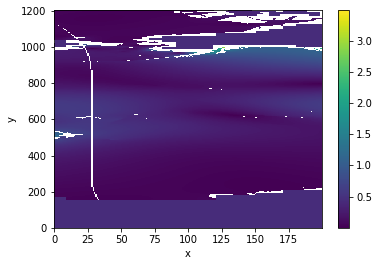

In [106]:
M2FESamp_on_SENEMO_GRID.isel(x=np.arange(400,600)).plot()

### Need to apply mask to regridded FES2014 data


In [165]:

# Create a land mask for the regridded FES data, with NaN over land
tl=domcfgZPS.top_level
tl=np.squeeze(tl)
tl=tl[1:-1,1:-1]
tl=tl.where(tl>0.5,drop=True)
tl
nanpatch=np.ones([151,1440])*np.nan
np.shape(nanpatch)
maskZPS=np.vstack((nanpatch,tl))


# Create a land mask for the MES grid, with NaN over land
tl=domcfgMES.top_level
tl=np.squeeze(tl)
tl=tl[1:-1,1:-1]
tl=tl.where(tl>0.5,drop=True)
tl
nanpatch=np.ones([151,1440])*np.nan
np.shape(nanpatch)
maskMES=np.vstack((nanpatch,tl))

M2FESamp_on_SENEMO_GRID_masked=M2FESamp_on_SENEMO_GRID*maskZPS
M2FESpha_on_SENEMO_GRID_masked=M2FESpha_on_SENEMO_GRID*maskZPS


In [118]:
# write regridded data to files

ds=M2FESamp_on_SENEMO_GRID_masked.to_dataset(name='M2amp')
ds.to_netcdf('../data/interim/FES2014_M2amp_on_SENEMO_GRID.nc')

ds=M2FESpha_on_SENEMO_GRID_masked.to_dataset(name='M2pha')
ds.to_netcdf('../data/interim/FES2014_M2pha_on_SENEMO_GRID.nc')

In [120]:
np.nanmax(m2fes.latitude[:])

87.916664

In [121]:
np.nanmax(M2FESpha_on_SENEMO_GRID.lat[:])

89.94787

In [122]:
np.nanmin(m2fes.latitude[:])

-88.0

In [123]:
np.nanmin(M2FESpha_on_SENEMO_GRID.lat[:])

-85.6

In [172]:
# calculate cell area appropriate for t-point variables (i.e. SSH, but not u, v) 
ZPScell_t_area=np.squeeze(domcfgZPS.e1t[0,1:-1,1:-1]*domcfgZPS.e2t[0,1:-1,1:-1])*maskZPS
MEScell_t_area=np.squeeze(domcfgMES.e1t[0,1:-1,1:-1]*domcfgMES.e2t[0,1:-1,1:-1])*maskMES

In [173]:
np.shape(maskMES)

(1205, 1440)

In [174]:
#sum the total area 
ZPS_cell_t_area_sum=ZPScell_t_area.sum(dim=None, keep_attrs=True)
MES_cell_t_area_sum=MEScell_t_area.sum(dim=None, keep_attrs=True)

In [175]:
ZPS_cell_t_area_sum

<xarray.DataArray ()>
array(3.61659935e+14)
Coordinates:
    time_counter  float64 0.0

In [176]:
difference_as_fraction=(MES_cell_t_area_sum-ZPS_cell_t_area_sum)/ZPS_cell_t_area_sum

In [177]:
difference_as_fraction

<xarray.DataArray ()>
array(-0.00218884)
Coordinates:
    time_counter  float64 0.0

In [178]:
MES_cell_t_area_sum

<xarray.DataArray ()>
array(3.60868318e+14)

In [196]:
#Calculate error in M2 w.r.t. FES2014, applying gridcell area weighting

err_ZPS_SSH_amp=(ZPS_SSH_amp[1:-1,1:-1]-M2FESamp_on_SENEMO_GRID)
err_MES_SSH_amp=(MES_SSH_amp[1:-1,1:-1]-M2FESamp_on_SENEMO_GRID)
err_IWD02_SSH_amp=(IWD02_SSH_amp[1:-1,1:-1]-M2FESamp_on_SENEMO_GRID)

#square the "errors" and apply gridcell area weights
err2_areawgt_ZPS_SSH_amp=err_ZPS_SSH_amp**2*ZPScell_t_area
err2_areawgt_MES_SSH_amp=err_MES_SSH_amp**2*MEScell_t_area
err2_areawgt_IWD02_SSH_amp=err_IWD02_SSH_amp**2*MEScell_t_area

#take the sqrt of the (sum of the squared, weighted errors, divided by the total area)
rmse_areawgt_GS1p1_tide_SSH_amp=np.sqrt(np.nansum(err2_areawgt_ZPS_SSH_amp)/ZPS_cell_t_area_sum)
rmse_areawgt_GS1p2_full_SSH_amp=np.sqrt(np.nansum(err2_areawgt_MES_SSH_amp)/MES_cell_t_area_sum)
rmse_areawgt_EXPIWD02_SSH_amp=np.sqrt(np.nansum(err2_areawgt_IWD02_SSH_amp)/MES_cell_t_area_sum)



In [197]:
rmse_areawgt_GS1p1_tide_SSH_amp

<xarray.DataArray ()>
array(0.12385321)
Coordinates:
    time_counter  float64 0.0

In [198]:
rmse_areawgt_GS1p2_full_SSH_amp

<xarray.DataArray ()>
array(0.13076302)

In [199]:
rmse_areawgt_IWD02_SSH_amp

<xarray.DataArray ()>
array(0.13012226)